# Подключение библиотек

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, norm, skew, kurtosis, expon, uniform
import pandas as pd


Для начала получим конретнно наши даныне 

In [2]:
# Путь к файлу
file_path = "tov_zapas_rozn_08-2025.xlsx"
sheet_name = "2"  # используем лист "2"

# 1) читаем лист без заголовков, чтобы найти, где расположены месяцы и нужный год
raw = pd.read_excel(file_path, sheet_name=sheet_name, header=None, dtype=object)

# ищем ячейку содержащую 'январ' и рядом год '2024' сверху
target_col = None
target_header_row = None
for r in range(raw.shape[0]):
    for c in range(raw.shape[1]):
        val = raw.iat[r, c]
        if isinstance(val, str) and 'январ' in val.lower():
            year_above = raw.iat[r-1, c] if r-1 >= 0 else None
            if isinstance(year_above, str) and '2024' in year_above:
                target_col = c
                target_header_row = r
                break
    if target_col is not None:
        break

if target_col is None:
    raise RuntimeError("Не найдено сочетание 'январь' + '2024' на листе. Проверьте файл/листы.")

print(f"Найден заголовок месяцев в строке (0-based): {target_header_row}, колонка (0-based): {target_col}")

# 2) читаем DataFrame с заголовком = строка с месяцами (чтобы колонки получили названия месяцев)
df = pd.read_excel(file_path, sheet_name=sheet_name, header=target_header_row)

# 3) Убедимся, что первая колонка — названия регионов; приведём её к имени "Регион"
first_col_name = df.columns[0]
df = df.rename(columns={first_col_name: "Регион"})

# 4) Возьмём именно ту колонку, которая соответствует найденному индексу target_col
#    (при чтении header сохраняется исходное количество колонок, поэтому можно обратиться по позиции)
jan_col_name = df.columns[target_col]
print("Колонка, выбранная для января 2024:", repr(jan_col_name))

# 5) Сформируем результат: Регион + значения января 2024
df_jan = df[["Регион", jan_col_name]].copy()
df_jan = df_jan.rename(columns={jan_col_name: "Запасы_дни_январь_2024"})

# 6) Уберём пустые регионы и агрегаты (страна/округа)
df_jan = df_jan[df_jan["Регион"].notna()].copy()
mask_agg = df_jan["Регион"].astype(str).str.contains(
    r"Российск|федеральн|итог|всего", case=False, na=False
)
df_jan_clean = df_jan[~mask_agg].copy()

# 7) Приведём значения к числовому типу (вдруг есть пробелы/строки)
df_jan_clean["Запасы_дни_январь_2024"] = pd.to_numeric(df_jan_clean["Запасы_дни_январь_2024"], errors="coerce")

# 8) Сбросим индекс и покажем результат
df_jan_clean = df_jan_clean.reset_index(drop=True)

print("Строк всего:", len(df_jan), "  После очистки:", len(df_jan_clean))
display(df_jan_clean.head(20))

Найден заголовок месяцев в строке (0-based): 4, колонка (0-based): 49
Колонка, выбранная для января 2024: 'январь.4'
Строк всего: 97   После очистки: 88


,Регион,Запасы_дни_январь_2024
0,Белгородская область,37.0
1,Брянская область,35.8
2,Владимирская область,40.0
3,Воронежская область,38.0
4,Ивановская область,37.0
5,Калужская область,37.0
6,Костромская область,42.0
7,Курская область,38.0
8,Липецкая область,43.0
9,Московская область,46.8


# Функция задание 
2 2.1. вариационный ряд;

2.2. группированный статистический ряд;

2.3. гистограмму;

2.4. эмпирическую плотность распределения (огибающую гистограммы).


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def analyze_data(data, column=None, bins="auto"):
    """
    Анализ данных: вариационный ряд, группировка и гистограмма с KDE.
    
    Parameters
    ----------
    data : pandas.DataFrame, list или np.array
        Исходные данные (может быть DataFrame с числовыми значениями).
    column : str, optional
        Название столбца для анализа (если передан DataFrame).
    bins : int, str или последовательность, optional
        Количество или способ выбора интервалов для гистограммы (по умолчанию "auto").
    """

    # --- Извлечение данных ---
    if column is not None:
        # Если подан DataFrame, извлекаем нужный столбец
        if hasattr(data, "loc"):
            series = data[column].dropna().values
        else:
            raise TypeError("Если указан параметр 'column', аргумент 'data' должен быть DataFrame.")
    else:
        # Если это просто список или массив
        series = np.asarray(data)
    
    # --- Преобразование к числам ---
    series = pd.to_numeric(series, errors='coerce')
    series = series[~np.isnan(series)]  # удаляем NaN

    n = len(series)
    print(f"\nАнализ столбца: {column if column else 'не указан (все данные)'}")
    print(f"Количество наблюдений: {n}")

    # --- Определяем число интервалов ---
    if bins == "auto":
        k = int(1 + 3.3 * np.log10(n))
        bins = k
        print(f"Число интервалов (по формуле Стерджесса): k = {k}")

    # --- Вариационный ряд ---
    variation_series = np.sort(series)
    print("\nВариационный ряд (фрагментарно):")
    if n >= 15:
        print("Первые 5:", variation_series[:5])
        print("Средние 5:", variation_series[n//2 - 2:n//2 + 3])
        print("Последние 5:", variation_series[-5:])
    else:
        print(variation_series)

    # --- Группированный статистический ряд ---
    counts, bin_edges = np.histogram(series, bins=bins)
    print("\nГруппированный статистический ряд (интервалы и частоты):")
    for i in range(len(counts)):
        print(f"[{bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}) : {counts[i]}")

    # --- Гистограмма ---
    plt.hist(series, bins=bin_edges, density=True, alpha=0.5,
             color='skyblue', edgecolor='black', label='Гистограмма')

    # --- KDE (ядровая оценка плотности) ---
    kde = gaussian_kde(series)
    x_grid = np.linspace(min(series), max(series), 500)
    plt.plot(x_grid, kde(x_grid), color='red', linewidth=2, label='Эмпирическая плотность (KDE)')

    plt.title(f"Гистограмма и эмпирическая плотность распределения\n({column if column else 'данные'})")
    plt.xlabel("Значения")
    plt.ylabel("Плотность")
    plt.legend()
    plt.show()

    return variation_series, (bin_edges, counts), kde


## Первичные данные для наглядного представления


Анализ столбца: Запасы_дни_январь_2024
Количество наблюдений: 87
Число интервалов (по формуле Стерджесса): k = 7

Вариационный ряд (фрагментарно):
Первые 5: [25. 28. 31. 33. 34.]
Средние 5: [40. 40. 41. 41. 42.]
Последние 5: [ 69.   92.   95.4 112.3 152. ]

Группированный статистический ряд (интервалы и частоты):
[25.00, 43.14) : 53
[43.14, 61.29) : 27
[61.29, 79.43) : 3
[79.43, 97.57) : 2
[97.57, 115.71) : 1
[115.71, 133.86) : 0
[133.86, 152.00) : 1


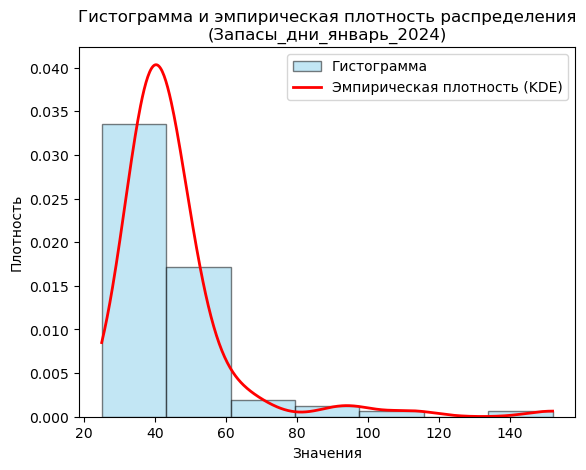

In [4]:
# Передаём датафрейм df_jan_clean и нужный столбец
variation_series, grouped, kde = analyze_data(
    df_jan_clean,
    column="Запасы_дни_январь_2024"
)

Обратим внимание что столбики гистограммы будто свидетельствуют о экспоненциальном распределении,  а вот эмпирическая плотность будто намекает нам на нормальное или логнормальное распределение с выбросами и тяжелым правым хвостом.

## Уберем выбросы выходящие за верхнюю границу значений

37.0 45.0 8.0 57.0
Удалено: 8 наблюдений

Анализ столбца: Запасы_дни_январь_2024
Количество наблюдений: 79
Число интервалов (по формуле Стерджесса): k = 7

Вариационный ряд (фрагментарно):
Первые 5: [25. 28. 31. 33. 34.]
Средние 5: [39. 40. 40. 40. 40.]
Последние 5: [51. 52. 54. 54. 54.]

Группированный статистический ряд (интервалы и частоты):
[25.00, 29.14) : 2
[29.14, 33.29) : 2
[33.29, 37.43) : 21
[37.43, 41.57) : 20
[41.57, 45.71) : 21
[45.71, 49.86) : 7
[49.86, 54.00) : 6


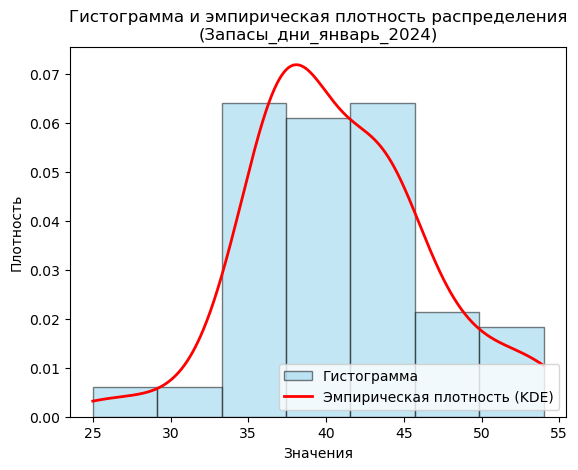

In [5]:
q1 = df_jan_clean["Запасы_дни_январь_2024"].quantile(0.25)
q3 = df_jan_clean["Запасы_дни_январь_2024"].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
print(q1, q3, iqr, upper_bound)
df_no_outliers = df_jan_clean[df_jan_clean["Запасы_дни_январь_2024"] <= upper_bound]
print("Удалено:", len(df_jan_clean) - len(df_no_outliers) - 1, "наблюдений")

# Передаём датафрейм и нужный столбец
variation_series, grouped, kde = analyze_data(
    df_no_outliers,
    column="Запасы_дни_январь_2024"
)



##  Построение boxplot для проверки о выбросах 

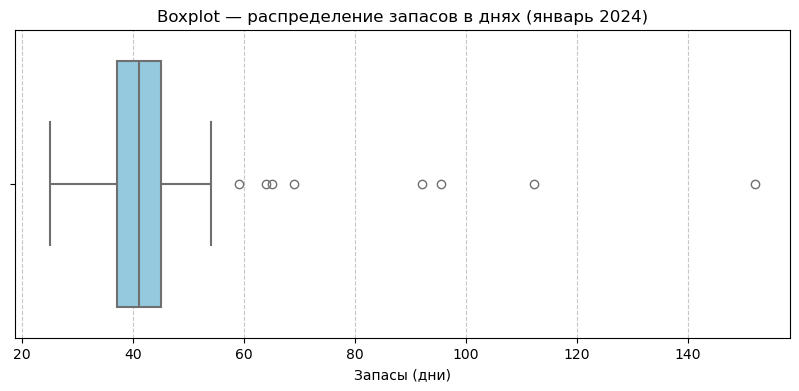

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.boxplot(
    x=df_jan_clean["Запасы_дни_январь_2024"],
    color="skyblue",
    fliersize=6,  # размер "усиков" (точек выбросов)
    linewidth=1.5
)
plt.title("Boxplot — распределение запасов в днях (январь 2024)")
plt.xlabel("Запасы (дни)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Функция задания 3

In [7]:

def sample_statistics(data, column=None):
    """
    Расчёт основных выборочных характеристик для числового столбца.
    
    Parameters
    ----------
    data : pd.DataFrame | array-like
        Исходные данные или DataFrame.
    column : str, optional
        Название столбца, если data — это DataFrame.
    """
    # --- Извлечение данных ---
    if isinstance(data, pd.DataFrame):
        if column is None:
            raise ValueError("Если передан DataFrame, необходимо указать название столбца (column).")
        series = pd.to_numeric(data[column], errors='coerce').dropna()
    else:
        series = pd.to_numeric(pd.Series(data), errors='coerce').dropna()

    arr = np.asarray(series)

    # --- Вычисления ---
    mean = np.mean(arr)
    var_biased = np.var(arr, ddof=0)
    var_unbiased = np.var(arr, ddof=1)
    std = np.std(arr, ddof=1)
    median = np.median(arr)
    mad = np.mean(np.abs(arr - median))
    q1, q2, q3 = np.percentile(arr, [25, 50, 75])
    iqr = q3 - q1
    q_mean = (q1 + q3) / 2
    xmin, xmax = np.min(arr), np.max(arr)
    data_range = xmax - xmin
    range_mean = (xmin + xmax) / 2
    skewness = skew(arr, bias=False)
    excess = kurtosis(arr, fisher=True, bias=False)

    stats = {
        "mean": mean,
        "var_biased": var_biased,
        "var_unbiased": var_unbiased,
        "std": std,
        "median": median,
        "mad": mad,
        "q1": q1, "q2": q2, "q3": q3,
        "iqr": iqr,
        "q_mean": q_mean,
        "xmin": xmin, "xmax": xmax,
        "range": data_range,
        "range_mean": range_mean,
        "skewness": skewness,
        "excess": excess
    }
    return pd.Series(stats)

def print_stat(stats_series, precision=4):

    """
    Красивый вывод выборочных характеристик с подписями.
    """
    names = {
        "mean": "Среднее значение (mean)",
        "var_biased": "Дисперсия смещённая (var_biased)",
        "var_unbiased": "Дисперсия несмещённая (var_unbiased)",
        "std": "Среднеквадратичное отклонение (std)",
        "median": "Медиана (med)",
        "mad": "Среднее абсолютное отклонение от медианы (mad)",
        "q1": "Первый квартиль (Q1)",
        "q2": "Второй квартиль / медиана (Q2)",
        "q3": "Третий квартиль (Q3)",
        "iqr": "Межквартильный размах (IQR)",
        "q_mean": "Среднее квартилей (Qmean)",
        "xmin": "Минимум (xmin)",
        "xmax": "Максимум (xmax)",
        "range": "Размах выборки (range)",
        "range_mean": "Среднее крайних значений (range_mean)",
        "skewness": "Асимметрия (skewness)",
        "excess": "Эксцесс (excess)"
    }

    print("📊 Основные выборочные характеристики:")
    print("-" * 60)
    for key, value in stats_series.items():
        name = names.get(key, key)
        print(f"{name:<45}: {value:.{precision}f}")
    print("-" * 60)

### Анализируем полные данные

In [8]:
normal_stats = sample_statistics(df_jan_clean, "Запасы_дни_январь_2024")
print_stat(normal_stats)

📊 Основные выборочные характеристики:
------------------------------------------------------------
Среднее значение (mean)                      : 45.1782
Дисперсия смещённая (var_biased)             : 300.7403
Дисперсия несмещённая (var_unbiased)         : 304.2373
Среднеквадратичное отклонение (std)          : 17.4424
Медиана (med)                                : 41.0000
Среднее абсолютное отклонение от медианы (mad): 8.4816
Первый квартиль (Q1)                         : 37.0000
Второй квартиль / медиана (Q2)               : 41.0000
Третий квартиль (Q3)                         : 45.0000
Межквартильный размах (IQR)                  : 8.0000
Среднее квартилей (Qmean)                    : 41.0000
Минимум (xmin)                               : 25.0000
Максимум (xmax)                              : 152.0000
Размах выборки (range)                       : 127.0000
Среднее крайних значений (range_mean)        : 88.5000
Асимметрия (skewness)                        : 3.9134
Эксцесс (excess)   

### Анализируем данные за исключением регионов с аномальными запасами

In [9]:
bv_stats = sample_statistics(df_no_outliers, "Запасы_дни_январь_2024")
print_stat(bv_stats)

📊 Основные выборочные характеристики:
------------------------------------------------------------
Среднее значение (mean)                      : 40.7823
Дисперсия смещённая (var_biased)             : 31.6630
Дисперсия несмещённая (var_unbiased)         : 32.0689
Среднеквадратичное отклонение (std)          : 5.6629
Медиана (med)                                : 40.0000
Среднее абсолютное отклонение от медианы (mad): 4.4329
Первый квартиль (Q1)                         : 37.0000
Второй квартиль / медиана (Q2)               : 40.0000
Третий квартиль (Q3)                         : 44.0000
Межквартильный размах (IQR)                  : 7.0000
Среднее квартилей (Qmean)                    : 40.5000
Минимум (xmin)                               : 25.0000
Максимум (xmax)                              : 54.0000
Размах выборки (range)                       : 29.0000
Среднее крайних значений (range_mean)        : 39.5000
Асимметрия (skewness)                        : 0.2410
Эксцесс (excess)        

## Функция для 4 задания

In [10]:
def additional_analysis(df, column, stats=None, theoretical_dist=None, params=None):
    """
    Дополнительный анализ распределения данных по выбранному столбцу датафрейма.

    Аргументы:
    ----------
    df : pd.DataFrame
        Исходный датафрейм
    column : str
        Название столбца с числовыми данными для анализа
    stats : pd.Series (опционально)
        Предварительно рассчитанные характеристики (из sample_statistics)
    theoretical_dist : объект из scipy.stats (например, norm, uniform, expon)
        Теоретическое распределение
    params : tuple
        Параметры распределения:
        - для norm: (loc, scale)
        - для uniform: (loc, scale) где scale = b - a
        - для expon: (loc, scale)
    """

    # --- Проверка входных данных ---
    if column not in df.columns:
        raise ValueError(f"Столбец '{column}' не найден в датафрейме.")

    data = df[column].dropna().values  # Убираем пропуски и берём массив

    if len(data) == 0:
        raise ValueError(f"В столбце '{column}' нет числовых данных для анализа.")

    # --- Если статистики не передали, считаем заново ---
    if stats is None:
        stats = sample_statistics(data)

    # --- 4.1 Абсолютное отклонение среднего от медианы ---
    dev_mean_median = abs(stats["mean"] - stats["median"])

    # --- 4.2 Абсолютное отклонение СКО от 0.5*IQR ---
    dev_std_iqr = abs(stats["std"] - stats["iqr"] / 2)

    # --- 4.3 Эмпирическая плотность (через KDE) ---
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), 500)
    emp_density = kde(x_grid)

    # --- 4.4 Теоретическая плотность (если задана) ---
    if theoretical_dist is not None and params is not None:
        theor_density = theoretical_dist.pdf(x_grid, *params)
        density_diff = np.trapezoid(np.abs(emp_density - theor_density), x_grid)
    else:
        theor_density = None
        density_diff = None

    # --- 4.5 Визуализация ---
    plt.figure(figsize=(8, 5))
    plt.plot(x_grid, emp_density, label="Эмпирическая плотность", color="red")
    if theor_density is not None:
        plt.plot(x_grid, theor_density, label=f"{theoretical_dist.name} (теоретическая)", color="blue", linestyle="--")

    plt.axvline(stats["mean"], color="green", linestyle="--", label=f"Среднее = {stats['mean']:.2f}")
    plt.axvline(stats["median"], color="purple", linestyle=":", label=f"Медиана = {stats['median']:.2f}")
    plt.axvline(stats["q1"], color="orange", linestyle=":", label=f"Q1 = {stats['q1']:.2f}")
    plt.axvline(stats["q3"], color="orange", linestyle=":", label=f"Q3 = {stats['q3']:.2f}")

    plt.title(f"Сравнение эмпирической и теоретической плотности для '{column}'")
    plt.xlabel(column)
    plt.ylabel("Плотность вероятности")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # --- 4.6 Результаты ---
    return pd.Series({
        "abs(mean - median)": dev_mean_median,
        "abs(std - 0.5*IQR)": dev_std_iqr,
        "density_diff": density_diff
    })


### Анализ гипотезы о  распределение с очищенными данными

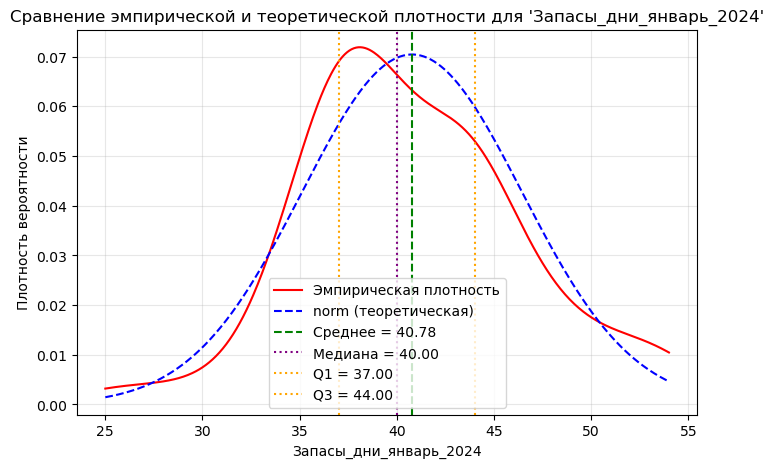

abs(mean - median)    0.782278
abs(std - 0.5*IQR)    2.162942
density_diff          0.147732
dtype: float64


In [11]:
# Параметры нормального распределения по выборке
params = (df_no_outliers["Запасы_дни_январь_2024"].mean(), df_no_outliers["Запасы_дни_январь_2024"].std())

# Анализ
result = additional_analysis(
    df_no_outliers,
    column="Запасы_дни_январь_2024",
    theoretical_dist=norm,
    params=params
)

print(result)

### Анализ гипотезы о распределении с полными данными

Параметры логнормального распределения:
 shape=0.2676, loc=0.0000, scale=43.2161


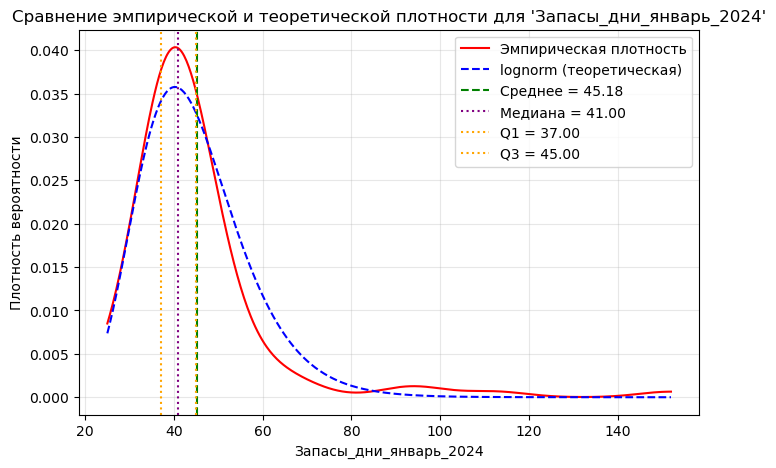

abs(mean - median)     4.178161
abs(std - 0.5*IQR)    13.442400
density_diff           0.183937
dtype: float64


In [12]:
from scipy.stats import lognorm
import numpy as np

# Берем данные из твоего DataFrame
data = df_jan_clean["Запасы_дни_январь_2024"].dropna().values

# --- 1. Оценим параметры логнормального распределения ---
# lognorm принимает параметры (s, loc, scale),
# где s = σ логарифма, loc = смещение (обычно 0), scale = exp(μ)

# оценка параметров по данным
shape, loc, scale = lognorm.fit(data, floc=0)

print(f"Параметры логнормального распределения:\n shape={shape:.4f}, loc={loc:.4f}, scale={scale:.4f}")

# --- 2. Вызываем твою функцию ---
result_lognorm = additional_analysis(
    df=df_jan_clean,
    column="Запасы_дни_январь_2024",
    theoretical_dist=lognorm,
    params=(shape, loc, scale)
)

print(result_lognorm)

## Интервальные оценки

In [13]:
from scipy.stats import t, chi2

def confidence_intervals(df, column, confidence=0.95):
    data = df[column].dropna()
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    var = std**2

    # Доверительный интервал для среднего
    t_crit = t.ppf((1 + confidence) / 2, df=n-1)
    mean_ci = (mean - t_crit * std / np.sqrt(n),
               mean + t_crit * std / np.sqrt(n))

    # Доверительный интервал для дисперсии
    chi2_lower = chi2.ppf((1 - confidence) / 2, df=n-1)
    chi2_upper = chi2.ppf((1 + confidence) / 2, df=n-1)
    var_ci = ((n-1)*var / chi2_upper, (n-1)*var / chi2_lower)

    return {
        "mean": mean,
        "mean_CI": mean_ci,
        "variance": var,
        "variance_CI": var_ci,
        "confidence": confidence
    }


In [14]:
ci_results = confidence_intervals(df_jan_clean, "Запасы_дни_январь_2024", confidence=0.95)
ci_results

{'mean': np.float64(45.17816091954023),
 'mean_CI': (np.float64(41.46068113694254), np.float64(48.895640702137925)),
 'variance': 304.23730820636183,
 'variance_CI': (np.float64(230.4349084290432), np.float64(420.388591604351)),
 'confidence': 0.95}

In [15]:
ci_results2 = confidence_intervals(df_no_outliers, "Запасы_дни_январь_2024", confidence=0.95)
ci_results2

{'mean': np.float64(40.78227848101266),
 'mean_CI': (np.float64(39.51384857760825), np.float64(42.05070838441707)),
 'variance': 32.06891269068484,
 'variance_CI': (np.float64(23.978840067042675), np.float64(45.0977554264682)),
 'confidence': 0.95}